In [51]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import rowgenerators as rg
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

%run ./lib.py


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# Apartment rent data from ApartmentList
`apartmentlist.com-rent_est-2017e2020-cbsa-1.1.1` Last Update: 2021-03-08T17:16:09

__


## Processing

Many of the `FIPS_Code` fields are null, but the name for the CBSA is taken directly from the Census names, so it is eacy to map them to geoids. The `geoid` column hold a Census ACS format geoid, taken from the name
## Documentation Links

* [Methodology](https://www.apartmentlist.com/research/rent-estimate-methodology) 
* [Download page](https://www.apartmentlist.com/research/category/data-rent-estimates) 

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)


## References
<ul><li> <strong>re_cbsa</string>, <em>data/Apartment_List_Rent_Estimates_CBSA_2021_2.csv</em>. Rent estimates by CBSA</li><li> <strong>cbsa</string>, <em>censusgeo://2020/5/US/CBSA</em>. CBSA Geographies</li><ul>

In [3]:
cbsa =  pkg.reference('cbsa').geoframe()
cbsa = cbsa.set_index('geoid')
cbsa_map = {r['name']:idx for idx, r in cbsa.iterrows()}

re_cbsa = pkg.reference('re_cbsa').dataframe()

In [4]:
re_cbsa['geoid'] = re_cbsa.CBSA_Name.apply(lambda n: cbsa_map.get(n))

In [5]:
re_cbsa[['CBSA_Name','FIPS_Code','geoid']]

,CBSA_Name,FIPS_Code,geoid
0,"Abilene, TX",10180.0,31000US10180
1,"Abilene, TX",10180.0,31000US10180
2,"Abilene, TX",10180.0,31000US10180
3,"Abilene, TX",10180.0,31000US10180
4,"Abilene, TX",10180.0,31000US10180
...,...,...,...
1416,"Poughkeepsie-Newburgh-Middletown, NY",NaN,31000US39100
1417,"Prescott Valley-Prescott, AZ",NaN,31000US39150
1418,"Dayton-Kettering, OH",NaN,31000US19430
1419,"Poughkeepsie-Newburgh-Middletown, NY",NaN,31000US39100


In [6]:
t = re_cbsa.loc[:, 'Bedroom_Size':].set_index(['geoid','Bedroom_Size'])
t = t.stack().to_frame('rent').reset_index().rename(columns={'level_2':'date'})
t['rent'] = pd.to_numeric(t.rent, errors='coerce')
t['date'] = t.date.apply(lambda v: pd.Timestamp(year=int(v.split('_')[0]),month=int(v.split('_')[1]),day=1, freq='M' ))
df = t.dropna().rename(columns={'Bedroom_Size':'bedrooms'})

In [58]:
t = df[(df.date.isin(['2021-02-01','2020-02-01'])) & (df.bedrooms == '_Overall')]
t = t.drop(columns=['bedrooms']).set_index(['geoid','date']).unstack()
t = t.droplevel(0, axis=1)
t.columns = ['2020','2021']
t['delta'] = ((t['2021'] - t['2020'])).round(2)
t['yoy'] = ((t['2021'] - t['2020'])/t['2020']*100).round(2)

yoy = t.join(cbsa[['name']]).sort_values('yoy',ascending=False)


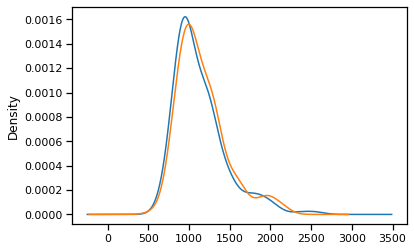

In [20]:
ax = yoy['2020'].plot.kde()
ax = yoy['2021'].plot.kde(ax=ax)

In [59]:
yoy['q2020'] = pd.qcut(t['2020'], 100).cat.codes
yoy['q2021'] = pd.qcut(t['2021'], 100).cat.codes

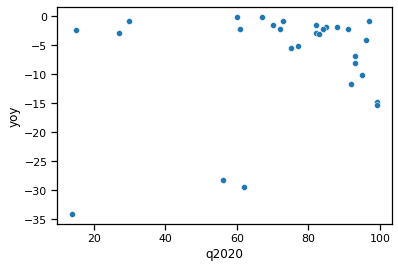

In [60]:
sns.scatterplot(y='yoy',x='q2020', data=yoy[yoy.yoy<0])

In [37]:
t[t.yoy<0].q2020.mean()

73.03448275862068

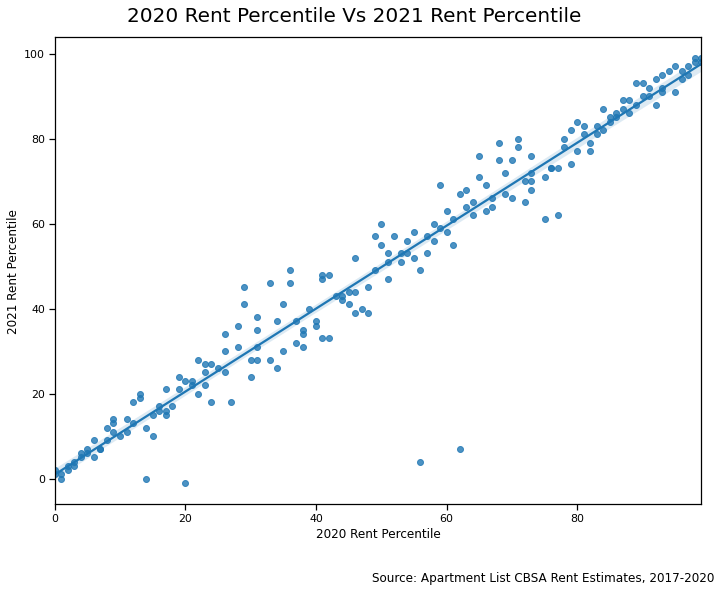

In [61]:
source='Apartment List CBSA Rent Estimates, 2017-2020'
with new_plot('2020 Rent Percentile Vs 2021 Rent Percentile', 
              source=source, figsize=(10,8), xlabel='2020 Rent Percentile', ylabel='2021 Rent Percentile') as (fig, ax):
    
    sns.regplot(y='q2021',x='q2020', data=yoy, ax=ax)


In [63]:
t = yoy.set_index('name')
(t['2021']/t['2020']).sort_values(ascending=True)

name
Odessa, TX                              0.658199
Midland, TX                             0.706186
Williston, ND                           0.716998
San Jose-Sunnyvale-Santa Clara, CA      0.846184
San Francisco-Oakland-Berkeley, CA      0.851539
                                          ...   
Riverside-San Bernardino-Ontario, CA    1.109954
York-Hanover, PA                        1.112288
Boise City, ID                          1.121775
Lake Charles, LA                        1.140988
Casper, WY                                   NaN
Length: 200, dtype: float64

In [79]:
import statsmodels.api as sm
t = yoy.set_index('name')
Y = t.q2021
X = t.q2020
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  q2021   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     2988.
Date:                Mon, 08 Mar 2021   Prob (F-statistic):          2.08e-121
Time:                        13:17:54   Log-Likelihood:                -680.18
No. Observations:                 200   AIC:                             1364.
Df Residuals:                     198   BIC:                             1371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9408      1.022      0.920      0.358      -1.075       2.956
q2020          0.9759      0.018     54.661      0.000       0.941       1.011
==============================================================================
Omnibus:                      205.194   Durbin-Watson:                   0.673
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6478.816
Skew:                          -3.914   Prob(JB):                         0.00
Kurtosis:                      29.762   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

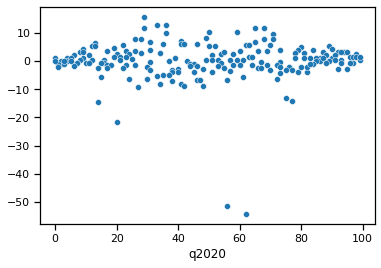

In [80]:
t = sns.scatterplot(x=t.q2020, y=results.resid)


In [88]:
results.resid.sort_values(ascending=True).head(6)

name
Midland, TX                               -54.447027
Williston, ND                             -51.591587
Casper, WY                                -21.458944
Odessa, TX                                -14.603503
Minneapolis-St. Paul-Bloomington, MN-WI   -14.085629
Chicago-Naperville-Elgin, IL-IN-WI        -13.133815
dtype: float64